In [1]:
# !pip install av

In [2]:
# !realpath train_vid2seq_c.ipynb

Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from functools import partial

# __all__ = ['resnet50', 'resnet101', 'resnet152', 'resnet200']

def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)

def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(out.size(0), planes - out.size(1), out.size(2), out.size(3), out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()
    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, head_conv=1):
        super(Bottleneck, self).__init__()
        if head_conv == 1:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
            self.bn1 = nn.BatchNorm3d(planes)
        elif head_conv == 3:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), bias=False, padding=(1, 0, 0))
            self.bn1 = nn.BatchNorm3d(planes)
        else:
            raise ValueError("Unsupported head_conv!")
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=(1, 3, 3), stride=(1, stride, stride), padding=(0, 1, 1), bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(i))
    ft_module_names.append('fc')

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})

    return parameters

class SlowFast(nn.Module):
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], class_num=27, shortcut_type='B', dropout=0.5,
                 alpha=8, beta=0.125):
        super(SlowFast, self).__init__()
        self.alpha = alpha
        self.beta = beta

        self.fast_inplanes = int(64 * beta)
        fast_inplanes = self.fast_inplanes
        self.fast_conv1 = nn.Conv3d(3, fast_inplanes, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3),
                                    bias=False)
        self.fast_bn1 = nn.BatchNorm3d(8)
        self.fast_relu = nn.ReLU(inplace=True)
        self.fast_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.fast_res1 = self._make_layer_fast(block, 8, layers[0], shortcut_type, head_conv=3)
        self.fast_res2 = self._make_layer_fast(
            block, 16, layers[1], shortcut_type, stride=2, head_conv=3)
        self.fast_res3 = self._make_layer_fast(
            block, 32, layers[2], shortcut_type, stride=2, head_conv=3)
        self.fast_res4 = self._make_layer_fast(
            block, 64, layers[3], shortcut_type, stride=2, head_conv=3)

        self.slow_inplanes = 64
        slow_inplanes = self.slow_inplanes
        self.slow_conv1 = nn.Conv3d(3, slow_inplanes, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3),
                                    bias=False)
        self.slow_bn1 = nn.BatchNorm3d(64)
        self.slow_relu = nn.ReLU(inplace=True)
        self.slow_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.slow_res1 = self._make_layer_slow(block, 64, layers[0], shortcut_type, head_conv=1)
        self.slow_res2 = self._make_layer_slow(
            block, 128, layers[1], shortcut_type, stride=2, head_conv=1)
        self.slow_res3 = self._make_layer_slow(
            block, 256, layers[2], shortcut_type, stride=2, head_conv=1)
        self.slow_res4 = self._make_layer_slow(
            block, 512, layers[3], shortcut_type, stride=2, head_conv=1)

        self.Tconv1 = nn.Conv3d(8, 16, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv2 = nn.Conv3d(32, 64, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv3 = nn.Conv3d(64, 128, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv4 = nn.Conv3d(128, 256, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)

        self.dp = nn.Dropout(dropout)
        self.fc = nn.Linear(self.fast_inplanes + self.slow_inplanes, class_num)

    def forward(self, input):
        fast, Tc = self.FastPath(input[:, :, ::2, :, :])
        slow = self.SlowPath(input[:, :, ::16, :, :], Tc)
        x = torch.cat([slow, fast], dim=1)
        x = self.dp(x)
        x = self.fc(x)
        return x

    def SlowPath(self, input, Tc):
        x = self.slow_conv1(input)
        x = self.slow_bn1(x)
        x = self.slow_relu(x)
        x = self.slow_maxpool(x)
        x = torch.cat([x, Tc[0]], dim=1)
        x = self.slow_res1(x)
        x = torch.cat([x, Tc[1]], dim=1)
        x = self.slow_res2(x)
        x = torch.cat([x, Tc[2]], dim=1)
        x = self.slow_res3(x)
        x = torch.cat([x, Tc[3]], dim=1)
        x = self.slow_res4(x)
        x = nn.AdaptiveAvgPool3d(1)(x)
        x = x.view(-1, x.size(1))
        return x

    def FastPath(self, input):
        x = self.fast_conv1(input)
        x = self.fast_bn1(x)
        x = self.fast_relu(x)
        x = self.fast_maxpool(x)
        Tc1 = self.Tconv1(x)
        x = self.fast_res1(x)
        Tc2 = self.Tconv2(x)
        x = self.fast_res2(x)
        Tc3 = self.Tconv3(x)
        x = self.fast_res3(x)
        Tc4 = self.Tconv4(x)
        x = self.fast_res4(x)
        x = nn.AdaptiveAvgPool3d(1)(x)
        x = x.view(-1, x.size(1))
        return x, [Tc1, Tc2, Tc3, Tc4]

    def _make_layer_fast(self, block, planes, blocks, shortcut_type, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.fast_inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.fast_inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=(1, stride, stride),
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.fast_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.fast_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.fast_inplanes, planes, head_conv=head_conv))
        return nn.Sequential(*layers)

    def _make_layer_slow(self, block, planes, blocks, shortcut_type, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.slow_inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.slow_inplanes + self.slow_inplanes // self.alpha * 2,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=(1, stride, stride),
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.slow_inplanes + self.slow_inplanes // self.alpha * 2, planes, stride, downsample,
                            head_conv=head_conv))
        self.slow_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.slow_inplanes, planes, head_conv=head_conv))

        return nn.Sequential(*layers)

def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model

def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model




Clr

In [ ]:
class OneCycle(object):
    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10 , div=10):
        self.nb = nb
        self.div = div
        self.step_len =  int(self.nb * (1- prcnt/100)/2)
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []

    def calc(self):
        self.iteration += 1
        lr = self.calc_lr()
        mom = self.calc_mom()
        return (lr, mom)

    def calc_lr(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        if self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
        elif self.iteration > self.step_len:
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr

    def calc_mom(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        if self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom




In [6]:
# pip install opencv-python==4.5.5.64

In [7]:
# pip install --upgrade pip

In [7]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import copy
import os
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import sys
import cv2

In [8]:
import os

data_path = '/root/tatneft/datasets/violations_dataset/cuts1_labels.txt'
with open(data_path, 'r') as file:
    classes = [line.strip() for line in file.readlines()]
print(classes)

decoder = {}
for i in range(len(classes)):
#     if str(i) not in {'0', '6', '7', '8', '9', '10', '13', '15', '17'}:
    decoder[classes[i]] = i

encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

print("Decoder:", decoder)
print("Encoder:", encoder)

['gas_analyzer', 'syringing', 'inspection', 'measure', 'pipe_work', 'HRW_work', 'pipe_up', 'pipe_down', 'cleaning', 'open_mouth', 'gaskets', 'spider_landing', 'unscrewing PCP', 'remove_PCP', 'unscrewing_PCP', 'crane_lowering', 'crane_lifting', 'PCP_roll', 'cross_rotation']
Decoder: {'gas_analyzer': 0, 'syringing': 1, 'inspection': 2, 'measure': 3, 'pipe_work': 4, 'HRW_work': 5, 'pipe_up': 6, 'pipe_down': 7, 'cleaning': 8, 'open_mouth': 9, 'gaskets': 10, 'spider_landing': 11, 'unscrewing PCP': 12, 'remove_PCP': 13, 'unscrewing_PCP': 14, 'crane_lowering': 15, 'crane_lifting': 16, 'PCP_roll': 17, 'cross_rotation': 18}
Encoder: {0: 'gas_analyzer', 1: 'syringing', 2: 'inspection', 3: 'measure', 4: 'pipe_work', 5: 'HRW_work', 6: 'pipe_up', 7: 'pipe_down', 8: 'cleaning', 9: 'open_mouth', 10: 'gaskets', 11: 'spider_landing', 12: 'unscrewing PCP', 13: 'remove_PCP', 14: 'unscrewing_PCP', 15: 'crane_lowering', 16: 'crane_lifting', 17: 'PCP_roll', 18: 'cross_rotation'}


In [10]:
id = list()

path = '/root/tatneft/datasets/violations_dataset/cuts1_train.txt'

with open(path, 'r') as file:
    for line in file:
        video_path, class_label = line.strip().split()
        id.append((video_path, int(class_label)))

print(len(id))
print(id[:5])

378
[('ch03_20231002080000_cut_000041_000046.mp4', 0), ('ch03_20231002080000_cut_000046_000051.mp4', 0), ('ch03_20231002080000_cut_000136_000141.mp4', 0), ('ch03_20231002080000_cut_000141_000146.mp4', 0), ('ch03_20231002080000_cut_000221_000226.mp4', 0)]


In [11]:
import cv2
import torch
from torch.utils.data import Dataset

class video_dataset(Dataset):
    def __init__(self, frame_list, sequence_length=16, transform=None, im_size=256):
        self.frame_list = frame_list
        self.transform = transform
        self.sequence_length = sequence_length
        self.im_size = im_size

    def __len__(self):
        return len(self.frame_list)

    def __getitem__(self, idx):
        path, label = self.frame_list[idx]
        path = '/root/tatneft/datasets/violations_dataset/cuts1/' + path

        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            raise ValueError(f"Не удалось открыть видео по пути: {path}")

        frames = []
        while len(frames) < self.sequence_length:
            ret, frame = cap.read()
            if not ret:
                break

            if self.transform:
                frame = self.transform(frame)

            frames.append(frame)

        cap.release()

        while len(frames) < self.sequence_length:
            frames.append(torch.zeros_like(frames[0]))

        seq_image = torch.stack(frames)  #форма: (sequence_length, channels, height, width)
        seq_image = seq_image.permute(1, 0, 2, 3)  #меняем порядок осей: (channels, sequence_length, height, width)

        return seq_image, label

In [12]:
im_size = 128
mean = [0.4889, 0.4887, 0.4891]
std = [0.2074, 0.2074, 0.2074]


train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

train_data = video_dataset(id,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 8,num_workers = 1 ,shuffle = True)


val_path = '/root/tatneft/datasets/violations_dataset/cuts1_val.txt'
val_id = []
with open(val_path, 'r') as file:
    for line in file:
        video_path, class_label = line.strip().split()
        val_id.append((video_path, int(class_label)))

val_data = video_dataset(val_id, sequence_length=10, transform=train_transforms)
val_loader = DataLoader(val_data, batch_size=8, num_workers=1, shuffle=False)
dataloaders = {'train':train_loader, 'val':val_loader}
print(dataloaders.keys())

dict_keys(['train', 'val'])


In [13]:
model = resnet200(class_num=19)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)
num_epochs = 20
onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)

In [17]:
# CUDA_LAUNCH_BLOCKING=1
# from sklearn.metrics import f1_score

# def calculate_metrics(outputs, labels):
#     _, preds = torch.max(outputs, 1)
#     accuracy = torch.sum(preds == labels).item() / len(labels)
#     f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
#     return accuracy, f1

In [18]:
# #НЕ ТО
# from tqdm import tqdm
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# def train_model(model, train_loader, val_loader, cls_criterion, optimizer, num_epochs, device):
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_f1 = 0.0
    
#     all_labels = []
#     all_preds = []
    
#     train_loss_graph = []

#     for epoch in range(num_epochs):
#         print(f'\n--- Epoch {epoch+1}/{num_epochs} ---')

#         model.train()
#         train_running_loss = 0.0
#         train_running_corrects = 0
#         train_labels = []
#         train_preds = []

#         for inputs, labels in tqdm(train_loader):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = cls_criterion(outputs, labels)

#             loss.backward()
#             optimizer.step()

#             train_running_loss += loss.item() * inputs.size(0)
#             train_running_corrects += torch.sum(preds == labels.data)
#             train_labels.extend(labels.cpu().numpy())
#             train_preds.extend(preds.cpu().numpy())
            
#             all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(preds.cpu().numpy())

#         train_epoch_loss = train_running_loss / len(train_loader.dataset)
#         train_loss_graph.append(train_epoch_loss)
#         train_epoch_acc = train_running_corrects.double() / len(train_loader.dataset)
#         train_epoch_f1 = f1_score(train_labels, train_preds, average='weighted')
#         train_epoch_prec = precision_score(train_labels, train_preds, average='weighted', zero_division = np.nan)
#         train_epoch_rec = recall_score(train_labels, train_preds, average='weighted')

# #         print(f'Train Loss: {train_epoch_loss:.4f} Prec: {train_epoch_prec:.4f} Rec: {train_epoch_rec:.4f} Acc: {train_epoch_acc:.4f} F1: {train_epoch_f1:.4f}')
# #         print(f'Train Loss: {train_epoch_loss:.4f}')

#         model.eval()
#         val_running_loss = 0.0
#         val_running_corrects = 0
#         val_labels = []
#         val_preds = []
#         val_loss_graph = []

#         with torch.no_grad():
#             for inputs, labels in tqdm(val_loader):
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = cls_criterion(outputs, labels)

#                 val_running_loss += loss.item() * inputs.size(0)
#                 val_running_corrects += torch.sum(preds == labels.data)
#                 val_labels.extend(labels.cpu().numpy())
#                 val_preds.extend(preds.cpu().numpy())
                
#                 all_labels.extend(labels.cpu().numpy())
#                 all_preds.extend(preds.cpu().numpy())

#         val_epoch_loss = val_running_loss / len(val_loader.dataset)
#         val_loss_graph.append(val_epoch_loss)
# #         val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
# #         val_epoch_f1 = f1_score(val_labels, val_preds, average='weighted')
# #         val_epoch_prec = precision_score(val_labels, val_preds, average='weighted', zero_division = np.nan)
# #         val_epoch_rec = recall_score(val_labels, val_preds, average='weighted')

# #         print(f'Val Loss: {val_epoch_loss:.4f} Prec: {val_epoch_prec:.4f} Rec: {val_epoch_rec:.4f} Acc: {val_epoch_acc:.4f} F1: {val_epoch_f1:.4f}\n')
# #         print(f'Val Loss: {val_epoch_loss:.4f})
    
#         print(f'-------------------------------Total_{epoch+1}-------------------------------')
#         all_epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
#         all_epoch_prec = precision_score(all_labels, all_preds, average='weighted', zero_division = np.nan) #исключены то, где нет результата
#         all_epoch_rec = recall_score(all_labels, all_preds, average='weighted')
#         all_epoch_ac = accuracy_score(all_labels, all_preds)
#         print(f'Train Loss: {train_epoch_loss:.4f} Val Loss: {val_epoch_loss:.4f}\n Prec: {all_epoch_prec:.4f} Rec: {all_epoch_rec:.4f} Acc: {all_epoch_ac:.4f} F1: {all_epoch_f1:.4f}\n')
        
#         if all_epoch_f1 > best_f1:
#             best_f1 = all_epoch_f1
#             best_model_wts = copy.deepcopy(model.state_dict())
#             torch.save({
#               'model_state_dict': model.state_dict(best_model_wts),
#             'optimizer_state_dict': optimizer.state_dict(),
#             }, f'/root/akhsup/res/model_v2s_{val_running_loss / len(val_loader.dataset):.4f}.pth')

#     print(f'Best F1: {best_f1:.4f}')
#     model.load_state_dict(best_model_wts)
#     return model

In [19]:
# model = model.to(device)
# model = train_model(model, train_loader, val_loader, cls_criterion, optimizer, num_epochs, device)


--- Epoch 1/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_1-------------------------------
Train Loss: 3.2563 Val Loss: 2.8685
 Prec: 0.1961 Rec: 0.2473 Acc: 0.2473 F1: 0.1955


--- Epoch 2/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.36s/it]


-------------------------------Total_2-------------------------------
Train Loss: 3.2444 Val Loss: 2.5187
 Prec: 0.1786 Rec: 0.2352 Acc: 0.2352 F1: 0.1929


--- Epoch 3/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


-------------------------------Total_3-------------------------------
Train Loss: 2.8907 Val Loss: 3.2633
 Prec: 0.1791 Rec: 0.2305 Acc: 0.2305 F1: 0.1903


--- Epoch 4/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


-------------------------------Total_4-------------------------------
Train Loss: 2.6592 Val Loss: 3.5958
 Prec: 0.1798 Rec: 0.2380 Acc: 0.2380 F1: 0.1935


--- Epoch 5/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


-------------------------------Total_5-------------------------------
Train Loss: 2.8406 Val Loss: 2.1324
 Prec: 0.1818 Rec: 0.2389 Acc: 0.2389 F1: 0.1946


--- Epoch 6/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_6-------------------------------
Train Loss: 2.6460 Val Loss: 2.4503
 Prec: 0.1829 Rec: 0.2414 Acc: 0.2414 F1: 0.1964


--- Epoch 7/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_7-------------------------------
Train Loss: 2.6373 Val Loss: 2.6161
 Prec: 0.1853 Rec: 0.2451 Acc: 0.2451 F1: 0.1995


--- Epoch 8/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_8-------------------------------
Train Loss: 2.6036 Val Loss: 3.3128
 Prec: 0.1960 Rec: 0.2492 Acc: 0.2492 F1: 0.2046


--- Epoch 9/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_9-------------------------------
Train Loss: 2.4297 Val Loss: 2.6418
 Prec: 0.2031 Rec: 0.2563 Acc: 0.2563 F1: 0.2112


--- Epoch 10/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_10-------------------------------
Train Loss: 2.2737 Val Loss: 2.4360
 Prec: 0.2114 Rec: 0.2652 Acc: 0.2652 F1: 0.2194


--- Epoch 11/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_11-------------------------------
Train Loss: 2.2582 Val Loss: 2.0408
 Prec: 0.2177 Rec: 0.2725 Acc: 0.2725 F1: 0.2260


--- Epoch 12/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_12-------------------------------
Train Loss: 2.1345 Val Loss: 2.1601
 Prec: 0.2232 Rec: 0.2774 Acc: 0.2774 F1: 0.2314


--- Epoch 13/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_13-------------------------------
Train Loss: 2.2249 Val Loss: 1.8783
 Prec: 0.2267 Rec: 0.2840 Acc: 0.2840 F1: 0.2378


--- Epoch 14/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_14-------------------------------
Train Loss: 2.0931 Val Loss: 1.8134
 Prec: 0.2322 Rec: 0.2909 Acc: 0.2909 F1: 0.2437


--- Epoch 15/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_15-------------------------------
Train Loss: 2.2516 Val Loss: 2.2375
 Prec: 0.2358 Rec: 0.2944 Acc: 0.2944 F1: 0.2473


--- Epoch 16/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_16-------------------------------
Train Loss: 2.0716 Val Loss: 2.2449
 Prec: 0.2386 Rec: 0.2980 Acc: 0.2980 F1: 0.2502


--- Epoch 17/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_17-------------------------------
Train Loss: 2.0082 Val Loss: 4.3608
 Prec: 0.2420 Rec: 0.3018 Acc: 0.3018 F1: 0.2546


--- Epoch 18/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_18-------------------------------
Train Loss: 1.9945 Val Loss: 2.2032
 Prec: 0.2471 Rec: 0.3074 Acc: 0.3074 F1: 0.2599


--- Epoch 19/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_19-------------------------------
Train Loss: 1.9692 Val Loss: 1.7219
 Prec: 0.2524 Rec: 0.3145 Acc: 0.3145 F1: 0.2664


--- Epoch 20/20 ---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]
/tmp/ipykernel_3375799/1369666589.py:98: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  'model_state_dict': model.state_dict(best_model_wts),


-------------------------------Total_20-------------------------------
Train Loss: 2.0408 Val Loss: 1.5724
 Prec: 0.2575 Rec: 0.3205 Acc: 0.3205 F1: 0.2723

Best F1: 0.2723


In [20]:
# import matplotlib.pyplot as plt
# plt.plot(train_loss_graph, label = "train loss", color = "blue")
# plt.plot(val_loss_graph, label = "val loss", color = "black")
# plt.show()

NameError: name 'train_loss_graph' is not defined

In [11]:
#БЫЛ ПЕРВЫЙ ПРОГОН НА ЭТОМ КОДЕ
# os.makedirs('/root/akhsup/weights', exist_ok=True)
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Для отладки
# from torch.autograd import Variable
# iteration = 0
# # acc_all = list()
# loss_all = list()

# model = model.to(device)

# for epoch in range(num_epochs):
#     print('')
#     print(f"--- Epoch {epoch} ---")
#     phase1 = dataloaders.keys()
#     for phase in tqdm(phase1):
#         print('')
#         print(f"--- Phase {phase} ---")
#         epoch_metrics = {"loss": [], "acc": []}
#         for batch_i, (X, y) in enumerate(dataloaders[phase]):
#             # Перемещаем данные на устройство (GPU)
#             image_sequences = Variable(X.to(device), requires_grad=True)
#             labels = Variable(y.to(device), requires_grad=False)
            
# #             print("Min label:", torch.min(labels).item())
# #             print("Max label:", torch.max(labels).item())
# #             assert torch.min(labels) >= 0 and torch.max(labels) < 19, "Метки классов выходят за пределы допустимого диапазона!"
            
# #             if torch.isnan(image_sequences).any() or torch.isinf(image_sequences).any():
# #                 print("Найдены NaN или Inf в данных!")
# #                 continue
            
#             optimizer.zero_grad()
#             predictions = model(image_sequences)
            
# #             if torch.isnan(predictions).any() or torch.isinf(predictions).any():
# #                 print("Найдены NaN или Inf в выходе модели!")
# #                 continue
            
#             loss = cls_criterion(predictions, labels)
#             acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()
#             loss.backward()
#             optimizer.step()
            
#             epoch_metrics["loss"].append(loss.item())
#             epoch_metrics["acc"].append(acc)
            
#             if phase == 'train':
#                 lr, mom = onecyc.calc()
#                 update_lr(optimizer, lr)
#                 update_mom(optimizer, mom)
            
#             batches_done = epoch * len(dataloaders[phase]) + batch_i
#             batches_left = num_epochs * len(dataloaders[phase]) - batches_done
#             sys.stdout.write(
#                 "\\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
#                 % (
#                     epoch,
#                     num_epochs,
#                     batch_i,
#                     len(dataloaders[phase]),
#                     loss.item(),
#                     np.mean(epoch_metrics["loss"]),
#                     acc,
#                     np.mean(epoch_metrics["acc"]),
#                 )
#             )

#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()

#         print('')
#         print('{} , acc: {}'.format(phase, np.mean(epoch_metrics["acc"])))
#         torch.save(model.state_dict(), '/root/akhsup/res/data.txt'.format(epoch))
#         if phase == 'train':
#             acc_all.append(np.mean(epoch_metrics["acc"]))
#             loss_all.append(np.mean(epoch_metrics["loss"]))


--- Epoch 0 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 2
Max label: 14
\r[Epoch 0/20] [Batch 0/48] [Loss: 2.696796 (2.696796), Acc: 12.50% (12.50%)]Min label: 1
Max label: 9
\r[Epoch 0/20] [Batch 1/48] [Loss: 3.601731 (3.149264), Acc: 0.00% (6.25%)]Min label: 0
Max label: 13
\r[Epoch 0/20] [Batch 2/48] [Loss: 3.097253 (3.131927), Acc: 12.50% (8.33%)]Min label: 1
Max label: 16
\r[Epoch 0/20] [Batch 3/48] [Loss: 3.050470 (3.111563), Acc: 0.00% (6.25%)]Min label: 1
Max label: 7
\r[Epoch 0/20] [Batch 4/48] [Loss: 3.228483 (3.134947), Acc: 12.50% (7.50%)]Min label: 0
Max label: 14
\r[Epoch 0/20] [Batch 5/48] [Loss: 3.551912 (3.204441), Acc: 0.00% (6.25%)]Min label: 2
Max label: 16
\r[Epoch 0/20] [Batch 6/48] [Loss: 2.968245 (3.170699), Acc: 12.50% (7.14%)]Min label: 1
Max label: 15
\r[Epoch 0/20] [Batch 7/48] [Loss: 2.790424 (3.123164), Acc: 12.50% (7.81%)]Min label: 1
Max label: 12
\r[Epoch 0/20] [Batch 8/48] [Loss: 2.792476 (3.086421), Acc: 0.00% (6.94%)]Min label: 2
Max label: 18
\r[Epoch 0/20] [Batch 9/48] [L

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:45<00:00, 105.56s/it]



--- Epoch 1 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 1
Max label: 17
\r[Epoch 1/20] [Batch 0/48] [Loss: 2.273354 (2.273354), Acc: 37.50% (37.50%)]Min label: 2
Max label: 16
\r[Epoch 1/20] [Batch 1/48] [Loss: 2.589894 (2.431624), Acc: 25.00% (31.25%)]Min label: 2
Max label: 12
\r[Epoch 1/20] [Batch 2/48] [Loss: 4.112683 (2.991977), Acc: 12.50% (25.00%)]Min label: 1
Max label: 16
\r[Epoch 1/20] [Batch 3/48] [Loss: 2.684614 (2.915136), Acc: 25.00% (25.00%)]Min label: 0
Max label: 6
\r[Epoch 1/20] [Batch 4/48] [Loss: 2.184447 (2.768998), Acc: 25.00% (25.00%)]Min label: 1
Max label: 18
\r[Epoch 1/20] [Batch 5/48] [Loss: 3.752126 (2.932853), Acc: 0.00% (20.83%)]Min label: 2
Max label: 18
\r[Epoch 1/20] [Batch 6/48] [Loss: 2.684476 (2.897370), Acc: 37.50% (23.21%)]Min label: 0
Max label: 12
\r[Epoch 1/20] [Batch 7/48] [Loss: 2.707988 (2.873698), Acc: 25.00% (23.44%)]Min label: 2
Max label: 15
\r[Epoch 1/20] [Batch 8/48] [Loss: 2.798624 (2.865356), Acc: 37.50% (25.00%)]Min label: 1
Max label: 15
\r[Epoch 1/20] [Ba

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.27s/it]



--- Epoch 2 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 2
Max label: 18
\r[Epoch 2/20] [Batch 0/48] [Loss: 2.541236 (2.541236), Acc: 12.50% (12.50%)]Min label: 3
Max label: 18
\r[Epoch 2/20] [Batch 1/48] [Loss: 2.316710 (2.428973), Acc: 25.00% (18.75%)]Min label: 2
Max label: 12
\r[Epoch 2/20] [Batch 2/48] [Loss: 2.342279 (2.400075), Acc: 12.50% (16.67%)]Min label: 2
Max label: 6
\r[Epoch 2/20] [Batch 3/48] [Loss: 2.531809 (2.433009), Acc: 37.50% (21.88%)]Min label: 2
Max label: 13
\r[Epoch 2/20] [Batch 4/48] [Loss: 2.373944 (2.421196), Acc: 25.00% (22.50%)]Min label: 2
Max label: 17
\r[Epoch 2/20] [Batch 5/48] [Loss: 3.037047 (2.523838), Acc: 37.50% (25.00%)]Min label: 3
Max label: 16
\r[Epoch 2/20] [Batch 6/48] [Loss: 1.763676 (2.415243), Acc: 12.50% (23.21%)]Min label: 1
Max label: 18
\r[Epoch 2/20] [Batch 7/48] [Loss: 1.933906 (2.355076), Acc: 37.50% (25.00%)]Min label: 1
Max label: 18
\r[Epoch 2/20] [Batch 8/48] [Loss: 2.657618 (2.388692), Acc: 12.50% (23.61%)]Min label: 1
Max label: 7
\r[Epoch 2/20] [Ba

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.34s/it]



--- Epoch 3 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 3
Max label: 12
\r[Epoch 3/20] [Batch 0/48] [Loss: 2.765605 (2.765605), Acc: 37.50% (37.50%)]Min label: 0
Max label: 18
\r[Epoch 3/20] [Batch 1/48] [Loss: 3.692962 (3.229283), Acc: 0.00% (18.75%)]Min label: 0
Max label: 5
\r[Epoch 3/20] [Batch 2/48] [Loss: 3.866565 (3.441710), Acc: 12.50% (16.67%)]Min label: 1
Max label: 14
\r[Epoch 3/20] [Batch 3/48] [Loss: 2.522653 (3.211946), Acc: 25.00% (18.75%)]Min label: 4
Max label: 14
\r[Epoch 3/20] [Batch 4/48] [Loss: 3.293823 (3.228321), Acc: 25.00% (20.00%)]Min label: 0
Max label: 8
\r[Epoch 3/20] [Batch 5/48] [Loss: 2.400167 (3.090296), Acc: 0.00% (16.67%)]Min label: 1
Max label: 17
\r[Epoch 3/20] [Batch 6/48] [Loss: 2.711093 (3.036124), Acc: 25.00% (17.86%)]Min label: 3
Max label: 16
\r[Epoch 3/20] [Batch 7/48] [Loss: 3.048850 (3.037715), Acc: 25.00% (18.75%)]Min label: 1
Max label: 13
\r[Epoch 3/20] [Batch 8/48] [Loss: 2.552564 (2.983809), Acc: 12.50% (18.06%)]Min label: 2
Max label: 13
\r[Epoch 3/20] [Batc

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.80s/it]



--- Epoch 4 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 3
Max label: 12
\r[Epoch 4/20] [Batch 0/48] [Loss: 2.446926 (2.446926), Acc: 25.00% (25.00%)]Min label: 1
Max label: 5
\r[Epoch 4/20] [Batch 1/48] [Loss: 1.171678 (1.809302), Acc: 37.50% (31.25%)]Min label: 0
Max label: 15
\r[Epoch 4/20] [Batch 2/48] [Loss: 2.138039 (1.918881), Acc: 25.00% (29.17%)]Min label: 0
Max label: 12
\r[Epoch 4/20] [Batch 3/48] [Loss: 2.315251 (2.017974), Acc: 37.50% (31.25%)]Min label: 3
Max label: 13
\r[Epoch 4/20] [Batch 4/48] [Loss: 2.741808 (2.162740), Acc: 50.00% (35.00%)]Min label: 1
Max label: 18
\r[Epoch 4/20] [Batch 5/48] [Loss: 4.994988 (2.634782), Acc: 25.00% (33.33%)]Min label: 1
Max label: 18
\r[Epoch 4/20] [Batch 6/48] [Loss: 3.866280 (2.810710), Acc: 25.00% (32.14%)]Min label: 1
Max label: 16
\r[Epoch 4/20] [Batch 7/48] [Loss: 4.326708 (3.000210), Acc: 37.50% (32.81%)]Min label: 1
Max label: 18
\r[Epoch 4/20] [Batch 8/48] [Loss: 2.874572 (2.986250), Acc: 25.00% (31.94%)]Min label: 3
Max label: 18
\r[Epoch 4/20] [B

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:46<00:00, 106.80s/it]



--- Epoch 5 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 0
Max label: 14
\r[Epoch 5/20] [Batch 0/48] [Loss: 2.829048 (2.829048), Acc: 50.00% (50.00%)]Min label: 2
Max label: 10
\r[Epoch 5/20] [Batch 1/48] [Loss: 2.624972 (2.727010), Acc: 50.00% (50.00%)]Min label: 1
Max label: 12
\r[Epoch 5/20] [Batch 2/48] [Loss: 2.187275 (2.547098), Acc: 37.50% (45.83%)]Min label: 3
Max label: 14
\r[Epoch 5/20] [Batch 3/48] [Loss: 3.409727 (2.762755), Acc: 25.00% (40.62%)]Min label: 3
Max label: 5
\r[Epoch 5/20] [Batch 4/48] [Loss: 1.087055 (2.427615), Acc: 37.50% (40.00%)]Min label: 2
Max label: 18
\r[Epoch 5/20] [Batch 5/48] [Loss: 2.284458 (2.403756), Acc: 12.50% (35.42%)]Min label: 1
Max label: 14
\r[Epoch 5/20] [Batch 6/48] [Loss: 1.962964 (2.340785), Acc: 25.00% (33.93%)]Min label: 0
Max label: 15
\r[Epoch 5/20] [Batch 7/48] [Loss: 2.599252 (2.373094), Acc: 12.50% (31.25%)]Min label: 1
Max label: 5
\r[Epoch 5/20] [Batch 8/48] [Loss: 1.539473 (2.280469), Acc: 37.50% (31.94%)]Min label: 1
Max label: 18
\r[Epoch 5/20] [Ba

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:44<00:00, 104.47s/it]



--- Epoch 6 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 3
Max label: 18
\r[Epoch 6/20] [Batch 0/48] [Loss: 1.258768 (1.258768), Acc: 50.00% (50.00%)]Min label: 0
Max label: 18
\r[Epoch 6/20] [Batch 1/48] [Loss: 2.030224 (1.644496), Acc: 37.50% (43.75%)]Min label: 1
Max label: 14
\r[Epoch 6/20] [Batch 2/48] [Loss: 0.966951 (1.418648), Acc: 62.50% (50.00%)]Min label: 2
Max label: 14
\r[Epoch 6/20] [Batch 3/48] [Loss: 3.268656 (1.881150), Acc: 25.00% (43.75%)]Min label: 0
Max label: 8
\r[Epoch 6/20] [Batch 4/48] [Loss: 3.696815 (2.244283), Acc: 25.00% (40.00%)]Min label: 2
Max label: 12
\r[Epoch 6/20] [Batch 5/48] [Loss: 2.234510 (2.242654), Acc: 25.00% (37.50%)]Min label: 2
Max label: 14
\r[Epoch 6/20] [Batch 6/48] [Loss: 3.022871 (2.354114), Acc: 25.00% (35.71%)]Min label: 1
Max label: 6
\r[Epoch 6/20] [Batch 7/48] [Loss: 2.159617 (2.329802), Acc: 50.00% (37.50%)]Min label: 1
Max label: 17
\r[Epoch 6/20] [Batch 8/48] [Loss: 2.232418 (2.318981), Acc: 25.00% (36.11%)]Min label: 2
Max label: 18
\r[Epoch 6/20] [Ba

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.18s/it]



--- Epoch 7 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 1
Max label: 5
\r[Epoch 7/20] [Batch 0/48] [Loss: 1.403922 (1.403922), Acc: 37.50% (37.50%)]Min label: 0
Max label: 6
\r[Epoch 7/20] [Batch 1/48] [Loss: 2.506375 (1.955148), Acc: 25.00% (31.25%)]Min label: 3
Max label: 13
\r[Epoch 7/20] [Batch 2/48] [Loss: 3.400728 (2.437008), Acc: 12.50% (25.00%)]Min label: 2
Max label: 18
\r[Epoch 7/20] [Batch 3/48] [Loss: 1.654185 (2.241302), Acc: 25.00% (25.00%)]Min label: 0
Max label: 13
\r[Epoch 7/20] [Batch 4/48] [Loss: 3.624128 (2.517867), Acc: 0.00% (20.00%)]Min label: 2
Max label: 12
\r[Epoch 7/20] [Batch 5/48] [Loss: 2.238045 (2.471230), Acc: 37.50% (22.92%)]Min label: 2
Max label: 18
\r[Epoch 7/20] [Batch 6/48] [Loss: 0.798436 (2.232260), Acc: 75.00% (30.36%)]Min label: 3
Max label: 15
\r[Epoch 7/20] [Batch 7/48] [Loss: 2.274561 (2.237547), Acc: 37.50% (31.25%)]Min label: 1
Max label: 5
\r[Epoch 7/20] [Batch 8/48] [Loss: 0.615389 (2.057308), Acc: 87.50% (37.50%)]Min label: 1
Max label: 16
\r[Epoch 7/20] [Batc

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.14s/it]



--- Epoch 8 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 1
Max label: 13
\r[Epoch 8/20] [Batch 0/48] [Loss: 1.634223 (1.634223), Acc: 62.50% (62.50%)]Min label: 1
Max label: 10
\r[Epoch 8/20] [Batch 1/48] [Loss: 2.329971 (1.982097), Acc: 37.50% (50.00%)]Min label: 1
Max label: 14
\r[Epoch 8/20] [Batch 2/48] [Loss: 1.280824 (1.748339), Acc: 62.50% (54.17%)]Min label: 2
Max label: 18
\r[Epoch 8/20] [Batch 3/48] [Loss: 1.197792 (1.610702), Acc: 62.50% (56.25%)]Min label: 0
Max label: 18
\r[Epoch 8/20] [Batch 4/48] [Loss: 2.010007 (1.690563), Acc: 50.00% (55.00%)]Min label: 1
Max label: 16
\r[Epoch 8/20] [Batch 5/48] [Loss: 1.946084 (1.733150), Acc: 50.00% (54.17%)]Min label: 1
Max label: 11
\r[Epoch 8/20] [Batch 6/48] [Loss: 1.754514 (1.736202), Acc: 62.50% (55.36%)]Min label: 3
Max label: 18
\r[Epoch 8/20] [Batch 7/48] [Loss: 1.625927 (1.722418), Acc: 50.00% (54.69%)]Min label: 1
Max label: 15
\r[Epoch 8/20] [Batch 8/48] [Loss: 2.440009 (1.802150), Acc: 37.50% (52.78%)]Min label: 1
Max label: 15
\r[Epoch 8/20] [

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:38<00:00, 98.98s/it]



--- Epoch 9 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 0
Max label: 5
\r[Epoch 9/20] [Batch 0/48] [Loss: 1.628313 (1.628313), Acc: 25.00% (25.00%)]Min label: 1
Max label: 6
\r[Epoch 9/20] [Batch 1/48] [Loss: 2.519852 (2.074083), Acc: 25.00% (25.00%)]Min label: 2
Max label: 13
\r[Epoch 9/20] [Batch 2/48] [Loss: 2.595345 (2.247837), Acc: 12.50% (20.83%)]Min label: 1
Max label: 15
\r[Epoch 9/20] [Batch 3/48] [Loss: 1.739439 (2.120738), Acc: 37.50% (25.00%)]Min label: 1
Max label: 18
\r[Epoch 9/20] [Batch 4/48] [Loss: 1.311188 (1.958828), Acc: 50.00% (30.00%)]Min label: 1
Max label: 15
\r[Epoch 9/20] [Batch 5/48] [Loss: 1.862291 (1.942738), Acc: 25.00% (29.17%)]Min label: 3
Max label: 16
\r[Epoch 9/20] [Batch 6/48] [Loss: 0.693951 (1.764340), Acc: 87.50% (37.50%)]Min label: 2
Max label: 11
\r[Epoch 9/20] [Batch 7/48] [Loss: 1.594914 (1.743162), Acc: 50.00% (39.06%)]Min label: 2
Max label: 18
\r[Epoch 9/20] [Batch 8/48] [Loss: 2.683070 (1.847596), Acc: 12.50% (36.11%)]Min label: 3
Max label: 18
\r[Epoch 9/20] [Ba

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:37<00:00, 97.43s/it]



--- Epoch 10 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 1
Max label: 18
\r[Epoch 10/20] [Batch 0/48] [Loss: 2.165782 (2.165782), Acc: 25.00% (25.00%)]Min label: 2
Max label: 15
\r[Epoch 10/20] [Batch 1/48] [Loss: 1.661118 (1.913450), Acc: 37.50% (31.25%)]Min label: 1
Max label: 11
\r[Epoch 10/20] [Batch 2/48] [Loss: 1.353642 (1.726847), Acc: 62.50% (41.67%)]Min label: 3
Max label: 12
\r[Epoch 10/20] [Batch 3/48] [Loss: 1.923532 (1.776018), Acc: 50.00% (43.75%)]Min label: 2
Max label: 14
\r[Epoch 10/20] [Batch 4/48] [Loss: 1.294778 (1.679770), Acc: 50.00% (45.00%)]Min label: 0
Max label: 7
\r[Epoch 10/20] [Batch 5/48] [Loss: 1.736363 (1.689202), Acc: 37.50% (43.75%)]Min label: 1
Max label: 12
\r[Epoch 10/20] [Batch 6/48] [Loss: 2.289976 (1.775027), Acc: 37.50% (42.86%)]Min label: 4
Max label: 12
\r[Epoch 10/20] [Batch 7/48] [Loss: 3.199398 (1.953073), Acc: 25.00% (40.62%)]Min label: 2
Max label: 4
\r[Epoch 10/20] [Batch 8/48] [Loss: 3.299858 (2.102716), Acc: 12.50% (37.50%)]Min label: 0
Max label: 18
\r[Epoch 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.51s/it]



--- Epoch 11 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 0
Max label: 15
\r[Epoch 11/20] [Batch 0/48] [Loss: 1.600030 (1.600030), Acc: 37.50% (37.50%)]Min label: 2
Max label: 16
\r[Epoch 11/20] [Batch 1/48] [Loss: 0.956315 (1.278173), Acc: 62.50% (50.00%)]Min label: 3
Max label: 5
\r[Epoch 11/20] [Batch 2/48] [Loss: 0.254546 (0.936964), Acc: 100.00% (66.67%)]Min label: 3
Max label: 18
\r[Epoch 11/20] [Batch 3/48] [Loss: 0.409368 (0.805065), Acc: 87.50% (71.88%)]Min label: 3
Max label: 18
\r[Epoch 11/20] [Batch 4/48] [Loss: 1.034323 (0.850917), Acc: 62.50% (70.00%)]Min label: 0
Max label: 12
\r[Epoch 11/20] [Batch 5/48] [Loss: 1.833696 (1.014713), Acc: 62.50% (68.75%)]Min label: 1
Max label: 14
\r[Epoch 11/20] [Batch 6/48] [Loss: 1.214273 (1.043222), Acc: 75.00% (69.64%)]Min label: 1
Max label: 16
\r[Epoch 11/20] [Batch 7/48] [Loss: 2.676020 (1.247321), Acc: 37.50% (65.62%)]Min label: 2
Max label: 18
\r[Epoch 11/20] [Batch 8/48] [Loss: 2.109903 (1.343164), Acc: 75.00% (66.67%)]Min label: 0
Max label: 16
\r[Epoc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:34<00:00, 94.82s/it]



--- Epoch 12 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 2
Max label: 15
\r[Epoch 12/20] [Batch 0/48] [Loss: 1.601955 (1.601955), Acc: 50.00% (50.00%)]Min label: 0
Max label: 5
\r[Epoch 12/20] [Batch 1/48] [Loss: 2.401782 (2.001868), Acc: 37.50% (43.75%)]Min label: 0
Max label: 18
\r[Epoch 12/20] [Batch 2/48] [Loss: 1.647304 (1.883680), Acc: 25.00% (37.50%)]Min label: 1
Max label: 12
\r[Epoch 12/20] [Batch 3/48] [Loss: 1.304092 (1.738783), Acc: 75.00% (46.88%)]Min label: 3
Max label: 16
\r[Epoch 12/20] [Batch 4/48] [Loss: 1.186968 (1.628420), Acc: 62.50% (50.00%)]Min label: 1
Max label: 12
\r[Epoch 12/20] [Batch 5/48] [Loss: 0.861087 (1.500531), Acc: 75.00% (54.17%)]Min label: 2
Max label: 16
\r[Epoch 12/20] [Batch 6/48] [Loss: 1.519900 (1.503298), Acc: 37.50% (51.79%)]Min label: 1
Max label: 14
\r[Epoch 12/20] [Batch 7/48] [Loss: 0.582354 (1.388180), Acc: 62.50% (53.12%)]Min label: 2
Max label: 14
\r[Epoch 12/20] [Batch 8/48] [Loss: 0.871362 (1.330756), Acc: 75.00% (55.56%)]Min label: 0
Max label: 12
\r[Epoch

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.84s/it]



--- Epoch 13 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 1
Max label: 16
\r[Epoch 13/20] [Batch 0/48] [Loss: 2.435503 (2.435503), Acc: 25.00% (25.00%)]Min label: 3
Max label: 16
\r[Epoch 13/20] [Batch 1/48] [Loss: 1.732130 (2.083817), Acc: 25.00% (25.00%)]Min label: 2
Max label: 17
\r[Epoch 13/20] [Batch 2/48] [Loss: 1.681514 (1.949716), Acc: 50.00% (33.33%)]Min label: 0
Max label: 15
\r[Epoch 13/20] [Batch 3/48] [Loss: 1.407465 (1.814153), Acc: 50.00% (37.50%)]Min label: 1
Max label: 12
\r[Epoch 13/20] [Batch 4/48] [Loss: 1.073760 (1.666074), Acc: 62.50% (42.50%)]Min label: 0
Max label: 16
\r[Epoch 13/20] [Batch 5/48] [Loss: 1.104483 (1.572476), Acc: 62.50% (45.83%)]Min label: 2
Max label: 5
\r[Epoch 13/20] [Batch 6/48] [Loss: 2.000367 (1.633603), Acc: 62.50% (48.21%)]Min label: 0
Max label: 18
\r[Epoch 13/20] [Batch 7/48] [Loss: 1.864771 (1.662499), Acc: 37.50% (46.88%)]Min label: 1
Max label: 16
\r[Epoch 13/20] [Batch 8/48] [Loss: 1.935858 (1.692872), Acc: 37.50% (45.83%)]Min label: 4
Max label: 16
\r[Epoch

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:34<00:00, 94.24s/it]



--- Epoch 14 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 3
Max label: 18
\r[Epoch 14/20] [Batch 0/48] [Loss: 0.347670 (0.347670), Acc: 100.00% (100.00%)]Min label: 0
Max label: 13
\r[Epoch 14/20] [Batch 1/48] [Loss: 1.726286 (1.036978), Acc: 37.50% (68.75%)]Min label: 1
Max label: 11
\r[Epoch 14/20] [Batch 2/48] [Loss: 1.474231 (1.182729), Acc: 62.50% (66.67%)]Min label: 3
Max label: 12
\r[Epoch 14/20] [Batch 3/48] [Loss: 0.780582 (1.082192), Acc: 75.00% (68.75%)]Min label: 1
Max label: 14
\r[Epoch 14/20] [Batch 4/48] [Loss: 0.705937 (1.006941), Acc: 62.50% (67.50%)]Min label: 0
Max label: 17
\r[Epoch 14/20] [Batch 5/48] [Loss: 2.145843 (1.196758), Acc: 37.50% (62.50%)]Min label: 1
Max label: 5
\r[Epoch 14/20] [Batch 6/48] [Loss: 2.069176 (1.321389), Acc: 62.50% (62.50%)]Min label: 1
Max label: 18
\r[Epoch 14/20] [Batch 7/48] [Loss: 0.546734 (1.224557), Acc: 62.50% (62.50%)]Min label: 0
Max label: 14
\r[Epoch 14/20] [Batch 8/48] [Loss: 1.239726 (1.226243), Acc: 75.00% (63.89%)]Min label: 0
Max label: 18
\r[Epo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:37<00:00, 97.86s/it]



--- Epoch 15 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 1
Max label: 18
\r[Epoch 15/20] [Batch 0/48] [Loss: 0.375288 (0.375288), Acc: 87.50% (87.50%)]Min label: 2
Max label: 18
\r[Epoch 15/20] [Batch 1/48] [Loss: 1.260379 (0.817833), Acc: 75.00% (81.25%)]Min label: 1
Max label: 5
\r[Epoch 15/20] [Batch 2/48] [Loss: 0.588934 (0.741534), Acc: 62.50% (75.00%)]Min label: 0
Max label: 18
\r[Epoch 15/20] [Batch 3/48] [Loss: 1.483199 (0.926950), Acc: 75.00% (75.00%)]Min label: 1
Max label: 5
\r[Epoch 15/20] [Batch 4/48] [Loss: 2.010948 (1.143750), Acc: 37.50% (67.50%)]Min label: 1
Max label: 11
\r[Epoch 15/20] [Batch 5/48] [Loss: 2.578280 (1.382838), Acc: 37.50% (62.50%)]Min label: 0
Max label: 14
\r[Epoch 15/20] [Batch 6/48] [Loss: 2.819110 (1.588020), Acc: 50.00% (60.71%)]Min label: 1
Max label: 6
\r[Epoch 15/20] [Batch 7/48] [Loss: 1.930641 (1.630847), Acc: 50.00% (59.38%)]Min label: 0
Max label: 16
\r[Epoch 15/20] [Batch 8/48] [Loss: 1.568407 (1.623910), Acc: 37.50% (56.94%)]Min label: 2
Max label: 12
\r[Epoch 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:35<00:00, 95.03s/it]



--- Epoch 16 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 3
Max label: 7
\r[Epoch 16/20] [Batch 0/48] [Loss: 1.882140 (1.882140), Acc: 25.00% (25.00%)]Min label: 1
Max label: 15
\r[Epoch 16/20] [Batch 1/48] [Loss: 1.381754 (1.631947), Acc: 37.50% (31.25%)]Min label: 0
Max label: 6
\r[Epoch 16/20] [Batch 2/48] [Loss: 1.586708 (1.616867), Acc: 25.00% (29.17%)]Min label: 0
Max label: 18
\r[Epoch 16/20] [Batch 3/48] [Loss: 2.010149 (1.715187), Acc: 25.00% (28.12%)]Min label: 1
Max label: 14
\r[Epoch 16/20] [Batch 4/48] [Loss: 0.825937 (1.537337), Acc: 75.00% (37.50%)]Min label: 1
Max label: 14
\r[Epoch 16/20] [Batch 5/48] [Loss: 0.651821 (1.389751), Acc: 62.50% (41.67%)]Min label: 3
Max label: 16
\r[Epoch 16/20] [Batch 6/48] [Loss: 0.535276 (1.267683), Acc: 75.00% (46.43%)]Min label: 1
Max label: 5
\r[Epoch 16/20] [Batch 7/48] [Loss: 1.089023 (1.245351), Acc: 62.50% (48.44%)]Min label: 0
Max label: 12
\r[Epoch 16/20] [Batch 8/48] [Loss: 2.780327 (1.415904), Acc: 25.00% (45.83%)]Min label: 3
Max label: 18
\r[Epoch 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:34<00:00, 94.23s/it]



--- Epoch 17 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 3
Max label: 5
\r[Epoch 17/20] [Batch 0/48] [Loss: 0.679238 (0.679238), Acc: 75.00% (75.00%)]Min label: 1
Max label: 14
\r[Epoch 17/20] [Batch 1/48] [Loss: 1.499328 (1.089283), Acc: 50.00% (62.50%)]Min label: 2
Max label: 11
\r[Epoch 17/20] [Batch 2/48] [Loss: 1.167634 (1.115400), Acc: 62.50% (62.50%)]Min label: 1
Max label: 16
\r[Epoch 17/20] [Batch 3/48] [Loss: 2.101424 (1.361906), Acc: 37.50% (56.25%)]Min label: 0
Max label: 15
\r[Epoch 17/20] [Batch 4/48] [Loss: 1.196248 (1.328774), Acc: 62.50% (57.50%)]Min label: 1
Max label: 15
\r[Epoch 17/20] [Batch 5/48] [Loss: 0.634364 (1.213039), Acc: 75.00% (60.42%)]Min label: 2
Max label: 13
\r[Epoch 17/20] [Batch 6/48] [Loss: 1.242476 (1.217245), Acc: 62.50% (60.71%)]Min label: 0
Max label: 12
\r[Epoch 17/20] [Batch 7/48] [Loss: 1.107763 (1.203559), Acc: 75.00% (62.50%)]Min label: 2
Max label: 7
\r[Epoch 17/20] [Batch 8/48] [Loss: 1.107584 (1.192895), Acc: 62.50% (62.50%)]Min label: 2
Max label: 18
\r[Epoch 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:34<00:00, 94.70s/it]



--- Epoch 18 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 1
Max label: 14
\r[Epoch 18/20] [Batch 0/48] [Loss: 0.964926 (0.964926), Acc: 75.00% (75.00%)]Min label: 1
Max label: 5
\r[Epoch 18/20] [Batch 1/48] [Loss: 0.525887 (0.745407), Acc: 87.50% (81.25%)]Min label: 1
Max label: 18
\r[Epoch 18/20] [Batch 2/48] [Loss: 1.550244 (1.013686), Acc: 50.00% (70.83%)]Min label: 3
Max label: 12
\r[Epoch 18/20] [Batch 3/48] [Loss: 0.969711 (1.002692), Acc: 75.00% (71.88%)]Min label: 1
Max label: 14
\r[Epoch 18/20] [Batch 4/48] [Loss: 0.568609 (0.915876), Acc: 75.00% (72.50%)]Min label: 3
Max label: 16
\r[Epoch 18/20] [Batch 5/48] [Loss: 0.506062 (0.847573), Acc: 75.00% (72.92%)]Min label: 2
Max label: 18
\r[Epoch 18/20] [Batch 6/48] [Loss: 0.822189 (0.843947), Acc: 87.50% (75.00%)]Min label: 1
Max label: 18
\r[Epoch 18/20] [Batch 7/48] [Loss: 1.248845 (0.894559), Acc: 62.50% (73.44%)]Min label: 1
Max label: 18
\r[Epoch 18/20] [Batch 8/48] [Loss: 1.006909 (0.907042), Acc: 50.00% (70.83%)]Min label: 1
Max label: 12
\r[Epoch

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:33<00:00, 93.67s/it]



--- Epoch 19 ---


  0%|                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


--- Phase train ---
Min label: 1
Max label: 12
\r[Epoch 19/20] [Batch 0/48] [Loss: 1.175706 (1.175706), Acc: 50.00% (50.00%)]Min label: 3
Max label: 15
\r[Epoch 19/20] [Batch 1/48] [Loss: 1.656593 (1.416150), Acc: 37.50% (43.75%)]Min label: 1
Max label: 18
\r[Epoch 19/20] [Batch 2/48] [Loss: 0.424914 (1.085738), Acc: 87.50% (58.33%)]Min label: 1
Max label: 18
\r[Epoch 19/20] [Batch 3/48] [Loss: 0.249340 (0.876638), Acc: 87.50% (65.62%)]Min label: 1
Max label: 17
\r[Epoch 19/20] [Batch 4/48] [Loss: 0.748298 (0.850970), Acc: 75.00% (67.50%)]Min label: 2
Max label: 12
\r[Epoch 19/20] [Batch 5/48] [Loss: 0.607309 (0.810360), Acc: 75.00% (68.75%)]Min label: 0
Max label: 12
\r[Epoch 19/20] [Batch 6/48] [Loss: 0.701953 (0.794873), Acc: 62.50% (67.86%)]Min label: 1
Max label: 16
\r[Epoch 19/20] [Batch 7/48] [Loss: 0.696588 (0.782588), Acc: 87.50% (70.31%)]Min label: 1
Max label: 12
\r[Epoch 19/20] [Batch 8/48] [Loss: 0.665768 (0.769608), Acc: 62.50% (69.44%)]Min label: 3
Max label: 18
\r[Epoc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:34<00:00, 94.19s/it]


In [12]:
import os
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

os.makedirs('/root/akhsup/weights', exist_ok=True)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

iteration = 0
train_losses = []
val_losses = []
precisions = []
recalls = []
f1_scores = []
train_loss = 0.0
val_loss = 0.0

model = model.to(device)

best_f1 = 0.0

for epoch in range(num_epochs):
    print('')
    print(f"--- Epoch {epoch+1} ---")
    
    for phase in dataloaders.keys():
        if phase == 'train':
            model.train()
        else:
            model.eval()

        epoch_loss = 0.0
        all_labels = []
        all_preds = []

        for batch_i, (X, y) in tqdm(enumerate(dataloaders[phase])):
            image_sequences = X.to(device)
            labels = y.to(device)
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                predictions = model(image_sequences)
                loss = cls_criterion(predictions, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item() * image_sequences.size(0)
            _, preds = torch.max(predictions, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            if phase == 'train':
                lr, mom = onecyc.calc()
                update_lr(optimizer, lr)
                update_mom(optimizer, mom)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        epoch_loss = epoch_loss / len(dataloaders[phase].dataset)

        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_loss = epoch_loss
        else:
            val_losses.append(epoch_loss)
            val_loss = epoch_loss
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

            if f1 > best_f1:
                best_f1 = f1
                best_epoch = epoch+1
                torch.save(model.state_dict(), f'/root/akhsup/weights/best_model_f1_{best_epoch}.pth')

    print(f"Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

#     torch.save(model.state_dict(), f'/root/akhsup/weights/model_epoch_{epoch+1}.pth')

print(f"Best F1-score: {best_f1:.4f} in epochs {epoch+1}")


--- Epoch 1 ---


48it [01:43,  2.15s/it]
10it [00:20,  2.05s/it]


Train_loss: 2.6855, Val_loss: 65.3912, Precision: 0.1157, Recall: 0.2785, F1: 0.1612

--- Epoch 2 ---


48it [01:37,  2.04s/it]
10it [00:19,  2.00s/it]


Train_loss: 2.6410, Val_loss: 3.8591, Precision: 0.1792, Recall: 0.2278, F1: 0.1901

--- Epoch 3 ---


48it [01:36,  2.02s/it]
10it [00:19,  1.99s/it]


Train_loss: 2.6023, Val_loss: 2.4220, Precision: 0.1760, Recall: 0.3038, F1: 0.2116

--- Epoch 4 ---


48it [01:39,  2.07s/it]
10it [00:20,  2.00s/it]


Train_loss: 2.6003, Val_loss: 2.1498, Precision: 0.2019, Recall: 0.2911, F1: 0.2326

--- Epoch 5 ---


48it [01:36,  2.02s/it]
10it [00:19,  1.98s/it]


Train_loss: 2.5035, Val_loss: 2.0964, Precision: 0.2764, Recall: 0.4557, F1: 0.3300

--- Epoch 6 ---


48it [01:39,  2.07s/it]
10it [00:19,  1.99s/it]

Train_loss: 2.4698, Val_loss: 2.0740, Precision: 0.2466, Recall: 0.3418, F1: 0.2723

--- Epoch 7 ---



48it [01:54,  2.38s/it]
10it [00:20,  2.05s/it]

Train_loss: 2.4280, Val_loss: 1.9892, Precision: 0.2316, Recall: 0.3038, F1: 0.2426

--- Epoch 8 ---



48it [01:37,  2.03s/it]
10it [00:20,  2.02s/it]

Train_loss: 2.4173, Val_loss: 3.6172, Precision: 0.1321, Recall: 0.2785, F1: 0.1739

--- Epoch 9 ---



48it [01:39,  2.08s/it]
10it [00:20,  2.01s/it]

Train_loss: 2.4288, Val_loss: 2.0961, Precision: 0.2880, Recall: 0.4430, F1: 0.3292

--- Epoch 10 ---



48it [01:37,  2.03s/it]
10it [00:20,  2.02s/it]

Train_loss: 2.1298, Val_loss: 1.9297, Precision: 0.3571, Recall: 0.3165, F1: 0.2943

--- Epoch 11 ---



48it [01:36,  2.02s/it]
10it [00:19,  2.00s/it]


Train_loss: 2.1147, Val_loss: 1.7433, Precision: 0.3899, Recall: 0.4304, F1: 0.3913

--- Epoch 12 ---


48it [01:38,  2.05s/it]
10it [00:20,  2.06s/it]

Train_loss: 2.0902, Val_loss: 1.7476, Precision: 0.4574, Recall: 0.3544, F1: 0.3323

--- Epoch 13 ---



48it [01:37,  2.03s/it]
10it [00:19,  1.99s/it]

Train_loss: 2.0066, Val_loss: 1.4516, Precision: 0.3391, Recall: 0.4177, F1: 0.3637

--- Epoch 14 ---



48it [01:40,  2.09s/it]
10it [00:20,  2.03s/it]

Train_loss: 1.7505, Val_loss: 1.6653, Precision: 0.3179, Recall: 0.3671, F1: 0.3296

--- Epoch 15 ---



48it [01:38,  2.05s/it]
10it [00:20,  2.02s/it]


Train_loss: 1.8837, Val_loss: 1.4327, Precision: 0.4706, Recall: 0.5443, F1: 0.4846

--- Epoch 16 ---


48it [01:38,  2.05s/it]
10it [00:20,  2.03s/it]

Train_loss: 1.7939, Val_loss: 1.5954, Precision: 0.3680, Recall: 0.4177, F1: 0.3639

--- Epoch 17 ---



48it [01:37,  2.02s/it]
10it [00:20,  2.00s/it]

Train_loss: 1.7613, Val_loss: 1.1609, Precision: 0.3662, Recall: 0.5949, F1: 0.4510

--- Epoch 18 ---



48it [01:37,  2.03s/it]
10it [00:19,  2.00s/it]

Train_loss: 1.4146, Val_loss: 1.3356, Precision: 0.4345, Recall: 0.4557, F1: 0.3942

--- Epoch 19 ---



48it [01:34,  1.97s/it]
10it [00:19,  1.97s/it]


Train_loss: 1.5187, Val_loss: 1.0230, Precision: 0.5884, Recall: 0.6962, F1: 0.6200

--- Epoch 20 ---


48it [01:35,  2.00s/it]
10it [00:19,  1.96s/it]

Train_loss: 1.3856, Val_loss: 1.0356, Precision: 0.5970, Recall: 0.6709, F1: 0.5832
Best F1-score: 0.6200 in epoch 20


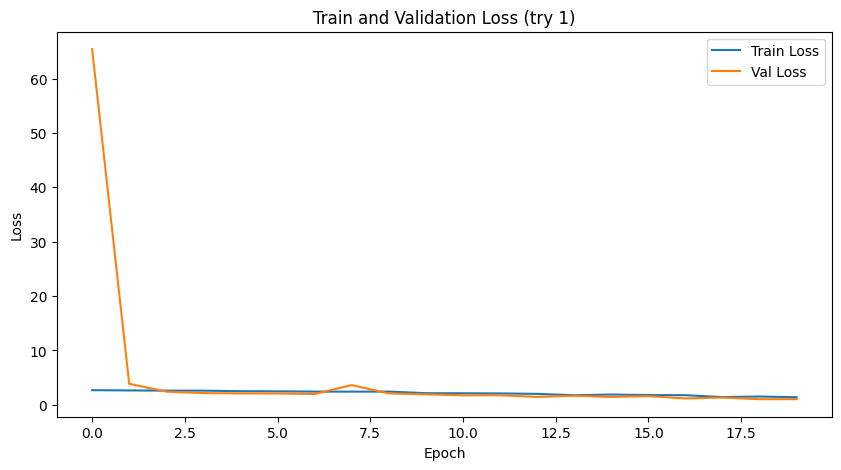

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss (try 1)')
plt.legend()
plt.savefig('/root/akhsup/weights/loss_plot.png')
plt.show()

In [9]:
def load_model(model_path, num_classes=19):
    model = resnet200(class_num=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def preprocess_video(video_path, sequence_length=10, im_size=128):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4889, 0.4887, 0.4891], std=[0.2074, 0.2074, 0.2074])
    ])

    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = transform(frame) 
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        raise ValueError(f"Ошибка: Видео '{video_path}' не содержит кадров или файл повреждён.")

    while len(frames) < sequence_length:
        frames.append(torch.zeros_like(frames[-1]))

    video_tensor = torch.stack(frames)  # (sequence_length, channels, height, width)
    video_tensor = video_tensor.permute(1, 0, 2, 3)  # (channels, sequence_length, height, width)
    return video_tensor.unsqueeze(0)  # Добавляем batch dimension: (1, channels, sequence_length, height, width)

def predict_video(model, video_tensor, device):
    with torch.no_grad():
        video_tensor = video_tensor.to(device)
        outputs = model(video_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

def test_video(model_path, video_path, encoder, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = load_model(model_path)
    model = model.to(device)

    video_tensor = preprocess_video(video_path)

    predicted_class = predict_video(model, video_tensor, device)
    
    predicted_label = encoder.get(predicted_class, "Unknown class")
#     print(f"Name of Predicted class: {predicted_label}")

#     print(f"Number of predicted class: {predicted_class}")
    return predicted_class

# if __name__ == "__main__":
#     model_path = "/root/akhsup/weights/best_model_f1_19.pth"
#     video_path = "/root/akhsup/test/test.mp4"
#     test_video(model_path, video_path, encoder)

In [39]:
#верно (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_002613_002618.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: measure
Number of predicted class: 3


In [40]:
#неверно долнжо быть 0 (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080000_cut_000036_000041.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: syringing
Number of predicted class: 1


In [41]:
#верно (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_001021_001026.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: syringing
Number of predicted class: 1


In [42]:
#верно (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_004400_004405.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: pipe_work
Number of predicted class: 4


In [43]:
#верно (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_005031_005036.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: HRW_work
Number of predicted class: 5


In [44]:
#неверно должен быть 7 (с валидации)
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
video_path = "/root/tatneft/datasets/violations_dataset/cuts1/ch03_20231002080315_cut_005304_005309.mp4"
test_video(model_path, video_path, encoder)

/tmp/ipykernel_762807/2322475451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Name of Predicted class: HRW_work
Number of predicted class: 5


In [ ]:
import pandas as pd
from moviepy.editor import VideoFileClip

df = pd.DataFrame(columns=['video', 'prediction', 'label', 'duration'])
model_path = "/root/akhsup/weights/best_model_f1_19.pth"
val_labels = []
with open('/root/tatneft/datasets/violations_dataset/cuts1_val.txt', 'r') as f:
        for line in f:
            video_file, label = line.strip().split()
            val_labels.append((video_file, int(label)))

for video, label in val_labels:
    video_path = '/root/tatneft/datasets/violations_dataset/cuts1/' + video
    predict = test_video(model_path, video_path, encoder)
    clip = VideoFileClip(video_path)
    new_row = {
        'video': video,
        'prediction': predict,
        'label': label, 
        'duration': clip.duration
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
print(df)
    

In [15]:
df.to_excel('results.xlsx', sheet_name='Sheet1', index=False)